# Sweden

Using Johns Hopkins data.

In [1]:
import matplotlib
import matplotlib.pyplot as p
import numpy as np
from datetime import datetime, timedelta, date
import csv
import os
import re
import math
from lib.common import *

matplotlib.__version__

'3.2.1'

In [36]:
DATA_DIRECTORY = 'data/johns-hopkins/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports'
SWEDISH_POPULATION = 10092454 # as of May 21, 2020
PER_MILLION_FACTOR = 1000000 / SWEDISH_POPULATION

In [43]:
os.makedirs(IMAGES_PATH)

In [44]:
from dataclasses import dataclass

@dataclass(frozen=True)
class JHUData:
    province: str
    country: str
    deaths: int
    confirmed: int
    recovered: int


def read_jhu_data(path):
    """
    Read and load one JHU data file. Returns a JHUData object.
    Only loads data for Sweden.
    """
    with open(path, mode='r', encoding='UTF-8') as f:
        c = csv.DictReader(f)
        for row in c:
            country = None
            for key in ('Country/Region', 'Country_Region'):
                try:
                    country = row[key]
                except KeyError:
                    pass

            if country is None:
                raise KeyError(f'Unable to find country field in "{path}".')

            if country == 'Sweden':
                result = JHUData(
                    province=row.get('Province/State', '').strip(),
                    country=country,
                    deaths=csv_int_field(row, 'Deaths'),
                    recovered=csv_int_field(row, 'Recovered'),
                    confirmed=csv_int_field(row, 'Confirmed')
                )
                break
        else:
            # No Sweden data found for this date.
            result = JHUData(province='', country='Sweden', deaths=0, recovered=0, confirmed=0)
            
        return result

def read_all():
    """
    Read all the data files in the appropriate JHU/CSSE directory. The data files
    are named after the date, in this format: 04-21-2020.csv. This function
    identifies all such files and reads them into a dictionary indexed by date.
    Each value in the dictionary is a another dictionary indexed by full state name
    and pointing to a JHUStateDate object.
    """
    results = dict()
    f_pat = re.compile(r'^([01]\d-[0123]\d-202\d)\.csv')
    for f in os.listdir(DATA_DIRECTORY):
        m = f_pat.match(f)
        if m is None:
            continue
        date = datetime.strptime(m.group(1), '%m-%d-%Y').date()
        results[date] = read_jhu_data(os.path.join(DATA_DIRECTORY, f))

    return results

In [45]:
sweden_data = read_all()
dates_in_order = sorted(sweden_data.keys())

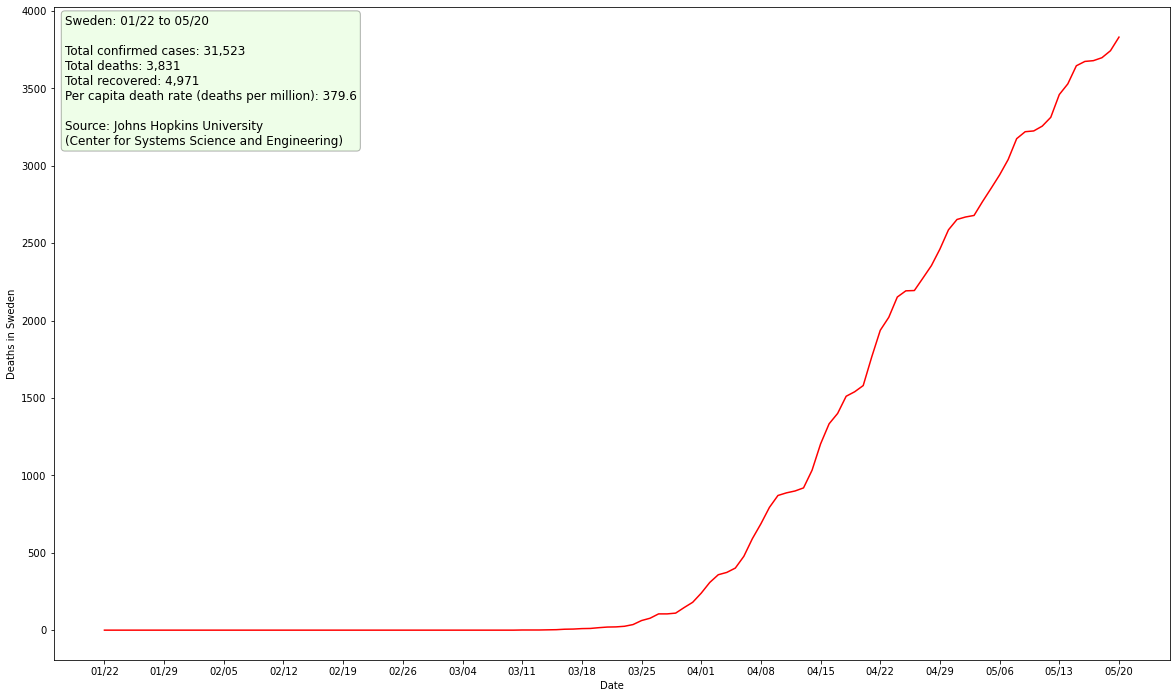

In [46]:
# Line chart plot of deaths.

fig, ax = p.subplots(figsize=(20, 12))
x_dates = [datestr(d) for d in dates_in_order]
total_deaths = []
total_cases = []
total_recovered = []

for date in dates_in_order:
    data = sweden_data[date]
    total_deaths.append(data.deaths)
    total_cases.append(data.confirmed)
    total_recovered.append(data.recovered)

ax.plot(x_dates, total_deaths, color='red', label='Deaths')
#ax.plot(x_dates, total_cases, color='blue', label='Confirmed Cases')
#ax.plot(x_dates, total_recovered, color='green', label='Recovered')

ax.set_xticks(x_dates[::7]) # X axis ticks every 7 days
ax.set_xlabel('Date')
ax.set_ylabel('Deaths in Sweden')
#ax.legend()
text = f"""Sweden: {x_dates[0]} to {x_dates[-1]}

Total confirmed cases: {total_cases[-1]:,}
Total deaths: {total_deaths[-1]:,}
Total recovered: {total_recovered[-1]:,}
Per capita death rate (deaths per million): {total_deaths[-1] * PER_MILLION_FACTOR:0.1f}

Source: Johns Hopkins University
(Center for Systems Science and Engineering)"""
textbox(ax, 0.01, 0.79, text)
fig.savefig(os.path.join(IMAGES_PATH, 'sweden.png'))